# Introducing Large Language Models

Import libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from tokenizers import Tokenizer
from tokenizers.models import BPE
import tokenizers.pre_tokenizers as pre_tokenizers
import tokenizers.processors as processors
import tokenizers.decoders as decoders
from tokenizers.trainers import BpeTrainer

In [2]:
torch.manual_seed(1357)

## Introducting Generative Pretrained Transformers (GPT)

In [3]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'  

## Data

In [4]:
with open('../xdata/input.txt','r',encoding='utf-8') as f:
    data = f.read()

Show first few lines

In [5]:
data[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

BPE Tokenization

In [6]:
tokenizer_path = Path('./')
tokenizer_path.mkdir(exist_ok=True)

tokenizer = Tokenizer(BPE())

tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
tokenizer.decoder = decoders.ByteLevel()
trainer = BpeTrainer(special_tokens=['<|endoftext|>'], min_frequency=2)

tokenizer.train(['../xdata/input.txt'],trainer)
tokenizer.save(str(tokenizer_path / 'input.json'))

Config

In [7]:
@dataclass
class Config:
    
    block_size = 256 # context-length
    batch_size = 64 # mini-batch size
    vocab_size = tokenizer.get_vocab_size()
    train_size = 0.9 
    n_embed = 384
    n_heads = 6
    head_size = n_embed // n_heads # computes to 384/6=64
    n_layers = 3
    train_iters = 500 # no. of batches to train on
    val_iters = 50 # no. of batches to validate on every eval_intervals
    eval_interval = 100 # validate after every eval_interval iterations while training
    lr = 5e-4
    attn_dropout = 0.2
    block_dropout = 0.2
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
Config.device, Config.vocab_size

('cpu', 12516)

Dataset Loader

In [15]:
class DatasetLoader:
    def __init__(self, Config, is_test=False) -> None:
        self.file_path = Path('../xdata/input.txt')
        self.tokenizer_path = Path('input.json')
        with open(self.file_path,'r',encoding='utf-8') as f:
            self.data = f.read()
        self.tokenizer = Tokenizer.from_file(str(self.tokenizer_path))
        
        self.full_data = torch.tensor(self.tokenizer.encode(self.data).ids, dtype=torch.long)
        
        self.is_test = is_test
        if self.is_test:
            self.data = self.full_data[int(Config.train_size*len(self.full_data)):]
        else:
            self.data = self.full_data[:int(Config.train_size*len(self.full_data))]

        self.block_size = Config.block_size
        self.batch_size = Config.batch_size

    def __len__(self) -> int:
        return len(self.data)

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.get_vocab_size()

    def __next__(self):
        ix = torch.randint(len(self.data) - self.block_size, (self.batch_size,))
        x = torch.stack([self.data[i:i+self.block_size] for i in ix])
        y = torch.stack([self.data[i+1:i+self.block_size+1] for i in ix])
        return x,y

Single Attention Head

In [9]:
class SingleHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

Multi-Head Attention

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([SingleHeadAttention(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x

Feed Forward Layer

In [11]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.ReLU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)

Transformer Block

In [12]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ff = FeedForward(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        
        return x

GPT

In [13]:
class GPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
      

Training

In [16]:
train_ds = DatasetLoader(Config)
val_ds = DatasetLoader(Config,is_test=True)

In [15]:
lm = GPT(Config)
lm = lm.to(device=Config.device)

In [ ]:
# summary(lm,input_size=(Config.batch_size, Config.block_size),dtypes=[torch.long],depth=5,)

Optimizer

In [17]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)

Loss Function

In [18]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

Validation loop

In [19]:
@torch.no_grad()
def valid_N_iters():
    val_step_losses = []
    for batch in tqdm(range(Config.val_iters)):
        inputs, targets = next(val_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        val_step_losses.append(loss.item())
        
        del inputs, targets, loss, logits
    
    val_loss = torch.tensor(val_step_losses).mean()
    print(f'val loss: {val_loss}')
    return val_loss

Training Loop

In [20]:
def train_N_iters():
    lm.train()
    train_step_losses = []
    val_losses = []
    for batch in tqdm(range(Config.train_iters)):
        optim.zero_grad()
        inputs, targets = next(train_ds)
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())
        
        if batch%(Config.train_iters//10)==0 or batch==Config.train_iters-1:
            print(f"\n{'-'*50}\nbatch {batch} train step loss: {loss.item()}")
            print(f"train loss so far: {torch.tensor(train_step_losses).mean()}\n{'-'*50}\n")
            
        if batch%Config.eval_interval==0 or batch==Config.train_iters-1:
            lm.eval()
            val_loss = valid_N_iters()
            lm.train()
            val_losses.append(val_loss.item())
            
            del val_loss
            
        del inputs, targets, loss, logits
        
    return train_step_losses, val_losses

In [21]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./')
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'basicGPT.pth'
    torch.save(state_dict, model_path)

In [22]:
def train_lm():
    train_step_losses,val_losses = train_N_iters()
    save_lm()
    return train_step_losses,val_losses

In [23]:
tsl,vl=train_lm()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/500 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

--------------------------------------------------
batch 0 train step loss: 9.609286308288574
train loss so far: 9.609286308288574
--------------------------------------------------



  0%|          | 0/50 [00:00<?, ?it/s]

val loss: 8.987764358520508

--------------------------------------------------
batch 50 train step loss: 5.794539928436279
train loss so far: 6.439533233642578
--------------------------------------------------


--------------------------------------------------
batch 100 train step loss: 5.595500946044922
train loss so far: 6.041148662567139
--------------------------------------------------



  0%|          | 0/50 [00:00<?, ?it/s]

val loss: 5.582905292510986

--------------------------------------------------
batch 150 train step loss: 5.180166721343994
train loss so far: 5.797584056854248
--------------------------------------------------


--------------------------------------------------
batch 200 train step loss: 4.906015396118164
train loss so far: 5.613602638244629
--------------------------------------------------



  0%|          | 0/50 [00:00<?, ?it/s]

val loss: 5.295295238494873

--------------------------------------------------
batch 250 train step loss: 4.825366020202637
train loss so far: 5.471171855926514
--------------------------------------------------


--------------------------------------------------
batch 300 train step loss: 4.734329700469971
train loss so far: 5.352146625518799
--------------------------------------------------



  0%|          | 0/50 [00:00<?, ?it/s]

val loss: 5.2390828132629395

--------------------------------------------------
batch 350 train step loss: 4.65593147277832
train loss so far: 5.25193452835083
--------------------------------------------------


--------------------------------------------------
batch 400 train step loss: 4.505341053009033
train loss so far: 5.162240982055664
--------------------------------------------------



  0%|          | 0/50 [00:00<?, ?it/s]

val loss: 5.225529670715332

--------------------------------------------------
batch 450 train step loss: 4.414461612701416
train loss so far: 5.084053993225098
--------------------------------------------------


--------------------------------------------------
batch 499 train step loss: 4.311504364013672
train loss so far: 5.016345500946045
--------------------------------------------------



  0%|          | 0/50 [00:00<?, ?it/s]

val loss: 5.263980865478516


In [24]:
tsl_mean = torch.tensor(tsl).mean()
print('Train Loss:',tsl_mean.item())

Train Loss: 5.016345500946045


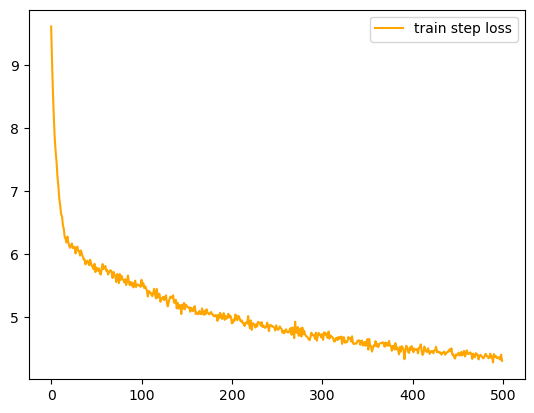

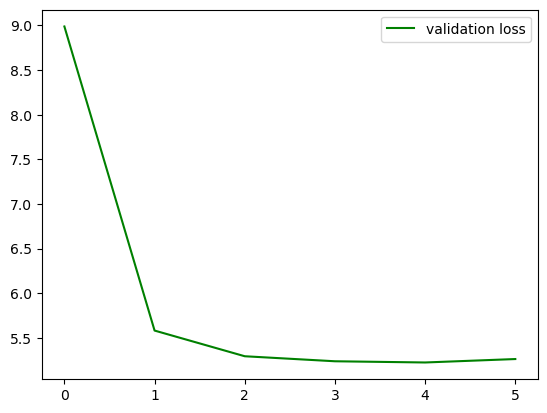

In [25]:
plt.plot(tsl,label='train step loss',color='orange')
plt.legend()
plt.show()
plt.plot(vl,label='validation loss',color='green')
plt.legend()
plt.show()

Generate text

In [26]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device)+61, # initial context 61 (i believe its \n)
    total=length
)
    generated = tokenizer.decode(generated[0].cpu().numpy())
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)

O, of mine own shroud, that things clear them, what we may not knowledge sovereignty.
WARWICK:
PRINCE EDWARD:
CAPULET: then be talked soul's cand commit be language, the most criesst glean it maruradvised
embra eye, sir?

CORIOLANUS:
Nay,

Found; such bands Aumerle, soft our council Warwick owe of mine, ista,
very peace. Look,
By meat sun exhales to thy house

And in the trumpets


generated (300 tokens)

Now Warwick to thyself more remedy: we doubt so muchn toucheswing, the suppli were it were--
By one father, newly gctde driKING HENRY VI:
Nay, and my trembling stand upon her princely hours pay?
Which we did I pray fall the first did find more than a fearfulaleare grace
More than woe disdain my lord, you, we proveetsactors,
That you are to the coffin my angry for bread,
That our former envied sevener stain your potency too more.

Out upon it shall pursue.
He's hearing!
Against a single to us both alone in the purpose,
Lie; and their years.
Since pile for no dru

In [27]:
with open('generated.txt','w') as f:
    for text in generated_texts:
        f.write(text)

## Evaluation